In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB



from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer


from sklearn.ensemble import BaggingClassifier, StackingClassifier, AdaBoostClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
df = pd.read_csv('./tokenized_dataframe.csv', index_col = [0])
df.head()

,subreddit,selftext,title,tokenized,title_length
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"['percentage', 'of', 'paycheck', 'into', 'defe...",62
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"['old', 'first', 'car', 'you', 'know', 'the', ...",40
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","['other', 'driver', 'ran', 'into', 'me', 'but'...",53
3,1,[removed],need help with a parent who’s reluctant to beg...,"['need', 'help', 'with', 'a', 'parent', 'who',...",76
4,1,[removed],how do i buy a house? how do i qualify? what’s...,"['how', 'do', 'i', 'buy', 'a', 'house', 'how',...",59


In [3]:
# def tokenize(column):
#     tokens = word_tokenize(column)
#     return [w for w in tokens if w.isalpha()]

# df['tokenized'] = df.apply(lambda x: tokenize(x['title']), axis = 1)
# df.head()

In [4]:
df['subreddit'].value_counts(normalize = True)

1    0.674061
0    0.325939
Name: subreddit, dtype: float64

In [5]:
X = df['title']
y = df['subreddit']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)


In [7]:
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))


1    0.674011
0    0.325989
Name: subreddit, dtype: float64
1    0.674208
0    0.325792
Name: subreddit, dtype: float64


## Logistic Regressor

In [8]:
lr = LogisticRegression

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter = 100_000))
])

pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [2, 4],
    'cvec__max_df': [1.0, .8, .5],
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']
}

gs_lr = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs = -1)

gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_) # from cross_val
gs_lr.best_params_

0.7461547575107199


/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461

{'cvec__max_df': 1.0,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__stop_words': None,
 'lr__penalty': 'l2'}

In [86]:
print(f' Training Accuracy Score: {gs_lr.score(X_train, y_train)}')
print(f' Test Accurancy Score: {gs_lr.score(X_test, y_test)}')

 Training Accuracy Score: 0.881678237247208
 Test Accurancy Score: 0.7429864253393665


In [10]:
predslr = gs_lr.predict(X_test)
predslr

array([1, 1, 0, ..., 1, 1, 1])

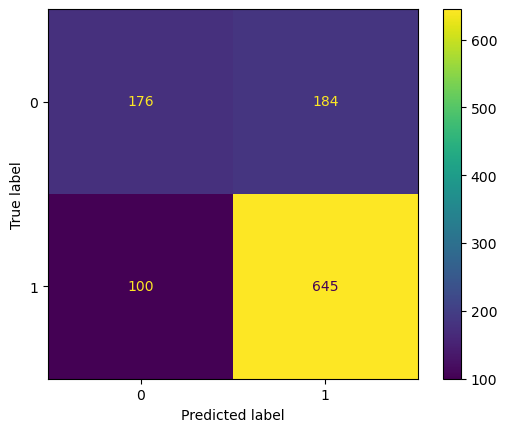

In [11]:
ConfusionMatrixDisplay.from_estimator(gs_lr.best_estimator_, X_test, y_test)

In [12]:
print(f' Training Misclassification Rate: {1 - gs_lr.score(X_train, y_train)}')
print(f' Test Misclassification Rate: {1 - gs_lr.score(X_test, y_test)}')

 Training Misclassification Rate: 0.11832176275279205
 Test Misclassification Rate: 0.25701357466063346


In [13]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predslr).ravel()


* specificity - negatives correctly diagnosed

In [14]:
spec = tn / (tn + fp)
spec

0.4888888888888889

* sensitivity / recall - actual positives correctly diagnosed


In [15]:
sens = tp / (tp + fn)
sens

0.8657718120805369

* precision - proportion of predicted positives correct

In [16]:
tp / (tp + fp)


0.7780458383594693

### * running Logistic regression with Tfid

In [17]:
lr = LogisticRegression

pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 100_000))
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__stop_words': [None, 'english'],
    #'ngram_range': [(1, 1), (2,2)],
    #'norm': ['l1', 'l2']
    
    
    
}

gs_lr_tf = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs = -1)

gs_lr_tf.fit(X_train, y_train)
print(gs_lr_tf.best_score_) # from cross_val
gs_lr_tf.best_params_

0.751588722870045


{'tfid__max_features': 2000, 'tfid__stop_words': None}

* Accuracy

In [87]:
print(f' Training Accuracy Score: {gs_lr_tf.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_lr_tf.score(X_test, y_test)}')

 Training Accuracy Score: 0.8194989435556898
 Test Accuracy Score: 0.7493212669683258


* Misclassification

In [19]:
print(f' Training Misclassification Rate: {1 - gs_lr_tf.score(X_train, y_train)}')
print(f' Test Misclassification Rate: {1 - gs_lr_tf.score(X_test, y_test)}')

 Training Misclassification Rate: 0.18050105644431025
 Test Misclassification Rate: 0.2506787330316742


In [20]:
predslrtf = gs_lr_tf.best_estimator_.predict(X_test)
predslrtf

array([1, 1, 1, ..., 1, 1, 1])

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predslrtf).ravel()

* specificity - negatives correctly diagnosed

In [21]:
spec = tn / (tn + fp)
spec

0.4888888888888889

* sensitivity / recall - actual positives correctly diagnosed


In [22]:
sens = tp / (tp + fn)
sens

0.8657718120805369

* precision - proportion of predicted positives correct

In [23]:
 tp / (tp + fp)

0.7780458383594693

* F1

In [24]:
f1_score(y_test, predslrtf)

0.8348240906380442

### Decision Tree

In [29]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__stop_words': [None, 'english'],
    'tfid__ngram_range': [(1, 1), (2,2)],
    'tfid__norm': ['l1', 'l2']
    
}

gs_dt = GridSearchCV(pipe,
                    param_grid = pipe_params, cv=3,
                    n_jobs = -1)

gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_)

{'tfid__max_features': 3000, 'tfid__ngram_range': (2, 2), 'tfid__norm': 'l1', 'tfid__stop_words': 'english'}


In [88]:
print(f' Training Accuracy Score: {gs_dt.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_dt.score(X_test, y_test)}')

 Training Accuracy Score: 0.8883187443404769
 Test Accuracy Score: 0.7113122171945702


In [31]:
print(f' Training Misclassification Rate: {1 - gs_dt.score(X_train, y_train)}')
print(f' Test Misclassification Rate: {1 - gs_dt.score(X_test, y_test)}')

 Training Misclassification Rate: 0.11168125565952314
 Test Misclassification Rate: 0.28868778280542984


In [32]:
predsdt = gs_dt.predict(X_test)

In [33]:
f1_score(y_test, predsdt)

0.8139941690962099

* still getting a high missclassification rate on test data, as well as a low F1 score. Neither logistic nor Decision tree performing extremely well so far

### Multinomial Naive Bayes

In [39]:
nb_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

nb_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2)],
    'tfid__norm': ['l1', 'l2']
}

gs_nb = GridSearchCV(nb_pipe,
                    param_grid = nb_pipe_params, cv = 5,
                    n_jobs = -1)

gs_nb.fit(X_train, y_train)
print(gs_nb.best_score_)
print(gs_nb.best_params_)

0.7533959435505552
{'tfid__max_features': 3000, 'tfid__min_df': 3, 'tfid__ngram_range': (1, 2), 'tfid__norm': 'l2', 'tfid__stop_words': None}


* Accuracy

In [89]:
print(f' Training Accuracy Score: {gs_nb.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_nb.score(X_test, y_test)}')

 Training Accuracy Score: 0.8098400241472985
 Test Accuracy Score: 0.746606334841629


* Missclassification Score

In [41]:
print(f' Training Misclassification Score: {1 - gs_nb.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_nb.score(X_test, y_test)}')

 Training Misclassification Score: 0.1901599758527015
 Testtest Misclassification Score: 0.25339366515837103


* Preds / F1 Score

In [42]:
preds_nb = gs_nb.predict(X_test)

In [43]:
f1_score(y_test, preds_nb)

0.838150289017341

### KNeighbors

In [92]:

knn_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

knn_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_knn = GridSearchCV(knn_pipe,
                    param_grid = knn_pipe_params, cv = 5,
                    n_jobs = -1)

gs_knn.fit(X_train, y_train)
print(gs_knn.best_score_)
print(gs_knn.best_params_)

/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

0.6139528737360619
{'tfid__max_features': 1000, 'tfid__min_df': 4, 'tfid__ngram_range': (1, 3), 'tfid__norm': 'l1', 'tfid__stop_words': 'english'}


* Accuracy Score

In [93]:
print(f' Training Accuracy Score: {gs_knn.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_knn.score(X_test, y_test)}')

 Training Accuracy Score: 0.7283428916389979
 Test Accuracy Score: 0.6171945701357466


* Misclassification Rate

In [51]:
print(f' Training Misclassification Score: {1 - gs_knn.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_knn.score(X_test, y_test)}')

 Training Misclassification Score: 0.2716571083610021
 Testtest Misclassification Score: 0.38280542986425337


Preds / F1 Score

In [52]:
preds_knn = gs_knn.predict(X_test)

In [53]:
f1_score(y_test, preds_knn)

0.7088781830695113

* knn is the worst model yet - already a high variance (prone to overfitting model), yes surprised it performed worst than decision tree

### Bagging

In [94]:
bagg_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('bagg', KNeighborsClassifier())
])

bagg_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_bagg = GridSearchCV(bagg_pipe,
                    param_grid = bagg_pipe_params, cv = 5,
                    n_jobs = -1)

gs_bagg.fit(X_train, y_train)
print(gs_bagg.best_score_)
print(gs_bagg.best_params_)

# with warnings.catch_warnings():
#  warnings.filterwarnings("ignore")

/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

0.6139528737360619
{'tfid__max_features': 1000, 'tfid__min_df': 4, 'tfid__ngram_range': (1, 3), 'tfid__norm': 'l1', 'tfid__stop_words': 'english'}


* Accuracy Score

In [95]:
print(f' Training Accuracy Score: {gs_bagg.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_bagg.score(X_test, y_test)}')

 Training Accuracy Score: 0.7283428916389979
 Test Accuracy Score: 0.6171945701357466


* Misclassification Score

In [96]:
print(f' Training Misclassification Score: {1 - gs_bagg.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_bagg.score(X_test, y_test)}')

 Training Misclassification Score: 0.2716571083610021
 Testtest Misclassification Score: 0.38280542986425337


* Preds / F1 

In [57]:
preds_bagg = gs_bagg.predict(X_test)

In [58]:
f1_score(y_test, preds_bagg)

0.7088781830695113

### Random Forest

In [63]:
rf_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_rf = GridSearchCV(rf_pipe,
                    param_grid = rf_pipe_params, cv = 5,
                    n_jobs = -1)

gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.7582247679457559
{'tfid__max_features': 1000, 'tfid__min_df': 2, 'tfid__ngram_range': (1, 2), 'tfid__norm': 'l1', 'tfid__stop_words': None}


* Accuracy

In [98]:
print(f' Training Accuracy Score: {gs_rf.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_rf.score(X_test, y_test)}')

 Training Accuracy Score: 0.9870208270449743
 Test Accuracy Score: 0.7429864253393665


* Misclassification Score

In [65]:
print(f' Training Misclassification Score: {1 - gs_rf.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_rf.score(X_test, y_test)}')

 Training Misclassification Score: 0.012979172955025708
 Testtest Misclassification Score: 0.25701357466063346


* Preds / F1

In [66]:
preds_rf = gs_rf.predict(X_test)

In [67]:
f1_score(y_test, preds_rf)

0.8264058679706602

### AdaBoost

In [68]:
ada_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

ada_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_ada = GridSearchCV(ada_pipe,
                    param_grid = ada_pipe_params, cv = 5,
                    n_jobs = -1)

gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)
print(gs_ada.best_params_)

0.7325723503438095
{'tfid__max_features': 1000, 'tfid__min_df': 2, 'tfid__ngram_range': (1, 3), 'tfid__norm': 'l1', 'tfid__stop_words': None}


* Accuracy

In [97]:
print(f' Training Accuracy Score: {gs_ada.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_ada.score(X_test, y_test)}')

 Training Accuracy Score: 0.7582251735587081
 Test Accuracy Score: 0.7285067873303167


* Misclassification Score

In [70]:
print(f' Training Misclassification Score: {1 - gs_ada.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_ada.score(X_test, y_test)}')

 Training Misclassification Score: 0.2417748264412919
 Testtest Misclassification Score: 0.2714932126696833


* Preds / F1

In [71]:
preds_ada = gs_ada.predict(X_test)

In [72]:
f1_score(y_test, preds_ada)

0.8255813953488373

### Stacking

In [74]:
level1_estimators = [
    ('nb', gs_nb.best_estimator_),
    ('ada', gs_ada.best_estimator_),
    ('rf', gs_rf.best_estimator_)
]

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression())

In [75]:
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('nb',
                                Pipeline(steps=[('tfid',
                                                 TfidfVectorizer(max_features=3000,
                                                                 min_df=3,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('mnb', MultinomialNB())])),
                               ('ada',
                                Pipeline(steps=[('tfid',
                                                 TfidfVectorizer(max_features=1000,
                                                                 min_df=2,
                                                                 ngram_range=(1,
                                                                              3),
                                                                 norm='l1')),
        

* Accuracy

In [99]:
print(f' Training Accuracy Score: {stacked_model.score(X_train, y_train)}')
print(f' Test Accuracy Score: {stacked_model.score(X_test, y_test)}')

 Training Accuracy Score: 0.9305765167521883
 Test Accuracy Score: 0.7547511312217194


* Misclassification Score

In [77]:
print(f' Training Misclassification Score: {1 - stacked_model.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - stacked_model.score(X_test, y_test)}')

 Training Misclassification Score: 0.06942348324781167
 Testtest Misclassification Score: 0.24524886877828056


* Preds / F1

In [79]:
preds_stacked_model = stacked_model.predict(X_test)

In [80]:
f1_score(y_test, preds_stacked_model)

0.8340477648499693

### Initial Thoughts

* Remember the baseline accuracy for personal finance was 67% the model is doing okay but definitely room for improvement

* Despite various models and even with stacking, all the models perform poorly, with KNN performing with worst with high variance (overfitting). Perhaps better feature engineering will help? Additional information from the data set to minimize misclassidications, increase the F1 score, and minimize overfitting while increasing accuracy test scores.

In [82]:
resids = y_test - preds_stacked_model

* great visualization from Simon about model's ability to make predictions


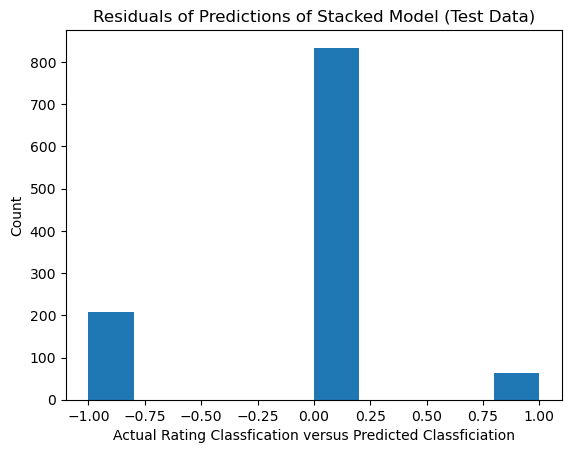

In [85]:

plt.hist(resids);
plt.title('Residuals of Predictions of Stacked Model (Test Data)');
plt.xlabel('Actual Rating Classfication versus Predicted Classficiation');
plt.ylabel('Count');

### Notes:

* what are some other visualizations I can incorporate to extract meaning data for decision making and model performance refinement???